In [1]:
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import ipyparallel as ipp
import pandas as pd
import numpy as np
import os
import seaborn as sns
from IPython.display import display
import csv

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression

import MESS
from MESS.util import set_params

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## set directory for analysis
analysis_dir = "/mnt/lfs2/ruff6699/Mess2.0/git/Figure4_Data/"

##make if doesn't exist
if not os.path.exists(analysis_dir):
    os.mkdir(analysis_dir)

/mnt/ceph/ruff6699/scratch/Mess2.0/minicoiconda2/envs/py2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
## PARRALELIZATION
## -------------------------------------------------------------------------------------------

## run the below line in terminal, not in jupyter notebooks
## this will start and ipcluster 
## ipcluster start -n 40 --cluster-id="MESS-Rich" --daemonize

## check to make sure the client is working
## should print the number of cores ready to go
ipyclient = ipp.Client(cluster_id="MESS-Rich")
print(len(ipyclient))

In [ ]:
## SIMULATIONS
## -------------------------------------------------------------------------------------------

## This chunk runs a bunch of simulations with different param combos
## DON'T RUN unless you want to wait forever

## set dir (again) bc just in case..
analysis_dir = "/mnt/lfs2/ruff6699/Mess2.0/git/Figure4_Data/"

## different param combinations to try
specrates = np.array([0.001])
localcomsize = np.array([500, 1000, 2000])

## go through all param combinations
params = [specrates, localcomsize]
params = list(itertools.product(*params))
for i, p in enumerate(params):
    specrates, localcomsize = p
    print(specrates, localcomsize)
    ldir = analysis_dir + "Speciation-{}/".format(specrates)
    if not os.path.exists(ldir):
        os.mkdir(ldir)
    ldir = ldir + "LocalComSize-{}".format(localcomsize)
    if not os.path.exists(ldir):
        os.mkdir(ldir)
    r = MESS.Region("sim-{}".format(i))
    r._log_files = True
    
    r.set_param("generations", 0.5)
    r.set_param("community_assembly_model", "*")
    r.set_param("S_m", 500)
    r.set_param("J", localcomsize)
    r.set_param("speciation_rate", specrates)
    r.set_param("project_dir", ldir)

    r.run(sims=4000, ipyclient=ipyclient, quiet=False)
    #r.run(sims=100, quiet=False) 

In [2]:
## RF OPTIMIZATION
## -------------------------------------------------------------------------------------------

## Here, estimate the best RF parameters to make a classifier that has the most power. 
## also stole this chunk from Isaac

## We will be using this data to tune the classification parameters
ldir = "/mnt/lfs2/ruff6699/Mess2.0/git/Figure4_Data/Speciation-0.001/LocalComSize-1000/SIMOUT.txt"
df = pd.read_csv(ldir, sep="\t", header=0)

## asign data
y = df['community_assembly_model']
X = df.loc[:, "S":"SGD_9"]

print(X.columns)
## split data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

## get best RF params
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

## Randomly search 100 different parameter combinations and take the
# ## one that reduces CV error
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(),\
                               param_distributions = random_grid,
                               n_iter = 10, cv = 3, verbose=0, n_jobs = -1, 
                               error_score=np.nan)

# ## fit the training data using best params for RF
rf_random.fit(Xtrain, ytrain)
#rf_random.fit(Xtrain, ytrain)
    
ypred = rf_random.predict(Xtest)
cm = metrics.confusion_matrix(ypred, ytest)
print(cm)

Index([u'S', u'abund_h1', u'abund_h2', u'abund_h3', u'abund_h4', u'pi_h1', u'pi_h2', u'pi_h3', u'pi_h4', u'mean_pi', u'std_pi', u'skewness_pi', u'kurtosis_pi', u'median_pi', u'iqr_pi', u'mean_dxys', u'std_dxys', u'skewness_dxys', u'kurtosis_dxys', u'median_dxys', u'iqr_dxys', u'trees', u'trait_h1', u'trait_h2', u'trait_h3', u'trait_h4', u'mean_local_traits', u'std_local_traits', u'skewness_local_traits', u'kurtosis_local_traits', u'median_local_traits', u'iqr_local_traits', u'mean_regional_traits', u'std_regional_traits', u'skewness_regional_traits', u'kurtosis_regional_traits', u'median_regional_traits', u'iqr_regional_traits', u'reg_loc_mean_trait_dif', u'reg_loc_std_trait_dif', u'reg_loc_skewness_trait_dif', u'reg_loc_kurtosis_trait_dif', u'reg_loc_median_trait_dif', u'reg_loc_iqr_trait_dif', u'abundance_dxy_cor', u'abundance_pi_cor', u'abundance_trait_cor', u'dxy_pi_cor', u'dxy_trait_cor', u'pi_trait_cor', u'SGD_0', u'SGD_1', u'SGD_2', u'SGD_3', u'SGD_4', u'SGD_5', u'SGD_6',
      

In [4]:
## RF CLASSIFICATION FUNCTION
## -------------------------------------------------------------------------------------------

## This chunk is the function to perform RF and cross validation to asses
## the error rates for each model

def RF_classify(df, rf_random, sims, genetic_flag = True, abund_flag = True, trait_flag = True):
    
    #print(rf_random.best_params_)
    
    ## split up the sumstats into their type, join later if all flags == True
    genX = pd.concat([df.loc[:, "pi_h1":"iqr_dxys"], df.loc[:, "SGD_0":"SGD_9"], df.loc[:,"dxy_pi_cor"]], axis=1)
    #genX = df.loc[:, "pi_h1":"iqr_dxys"]
    abundX = df.loc[:, "S":"abund_h4"]  
    traitX = df.loc[:, "trait_h1":"reg_loc_iqr_trait_dif"] 
    
    ## correlation sum stats
    gen_traitX = df.loc[:, "dxy_trait_cor":"pi_trait_cor"]
    gen_abundX = df.loc[:, "abundance_dxy_cor":"abundance_pi_cor"]
    abund_traitX = df.loc[:, "abundance_trait_cor"]
    
    ## y will always be this
    y = df['community_assembly_model']
    
    ## begin X as this
    X = df['community_assembly_model']
    
    ## add certain sumstats depending on which flag is on
    if genetic_flag == True:
        X = pd.concat([X, genX], axis=1)
    if abund_flag == True:
        X = pd.concat([X, abundX], axis=1)
    if trait_flag == True:  
        X = pd.concat([X, traitX], axis=1)
    
    ## add certain sumstats if multiple flags are on
    if genetic_flag == True & trait_flag == True:
        X = pd.concat([X, gen_traitX], axis=1)
    if genetic_flag == True & abund_flag == True:
        X = pd.concat([X, gen_abundX], axis=1) 
    if abund_flag == True & trait_flag == True:
        X = pd.concat([X, abund_traitX], axis=1) 
        
    ## drop that first column, you don't need it bc the info is in y
    X = X.drop(['community_assembly_model'], axis=1)

    #y = df['community_assembly_model']
    #X = df.loc[:, "S":"SGD_9"]

    # split data
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)  

    model = RandomForestClassifier(n_estimators=rf_random.best_params_["n_estimators"], \
                                   n_jobs=-1, max_features='auto', max_depth=rf_random.best_params_["max_depth"], \
                                   bootstrap=rf_random.best_params_["bootstrap"], \
                                   min_samples_split=rf_random.best_params_["min_samples_split"], \
                                   min_samples_leaf=rf_random.best_params_["min_samples_leaf"])

    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    cm = metrics.confusion_matrix(ypred, ytest)
    print(cm)

    mean = []
    stder = []

    for i in range(0,3):
        #competition first, then filtering, then neutral, then average 
        acuracy = float(cm[i][i])
        total = float(sum([cm[0][i], cm[1][i], cm[2][i]]))
        z = int(total)-int(acuracy)
        Accuracy_array = np.concatenate([np.ones(int(acuracy)), np.zeros(z)])
        
        mean.append(np.mean(Accuracy_array))
        stder.append(np.std(Accuracy_array)/np.sqrt(sims))
        
        #err.append( [np.mean(Accuracy_array), np.std(Accuracy_array)/np.sqrt(sims) ])
        
    #append avg error rate from our own external validation
    #err.append(np.mean(err))    
    
    #err.append( [np.mean(Accuracy_array), np.std(Accuracy_array)/np.sqrt(sims)] )
    
#     #also append average error rate from cv function
#     scores = cross_val_score(model, Xtrain, ytrain, cv=5)
#     err.append(scores.mean()) 

    return mean, stder

In [6]:

localcomsize = np.array([500.0, 1000.0, 2000.0])

MnAccuracy = pd.DataFrame(columns=['Mn.comp','Mn.filt','Mn.neut'])
StdAccuracy = pd.DataFrame(columns=['Std.comp','Std.filt','Std.neut'])

for i in localcomsize:
    ldir = "/mnt/lfs2/ruff6699/Mess2.0/git/Figure4_Data/Speciation-0.001/"
    ldir = ldir + "LocalComSize-{}/".format(i)
    ldir = ldir + "SIMOUT.txt"
    print(ldir)
    df = pd.read_csv(ldir, sep="\t", header=0)
    sims = len(df)
    
    classify_model = RF_classify(df, rf_random, sims)
    print(classify_model)
    MnAccuracy.loc[i] = classify_model[0]
    StdAccuracy.loc[i] = classify_model[1]


print(MnAccuracy)
print(StdAccuracy)


/mnt/lfs2/ruff6699/Mess2.0/git/Figure4_Data/Speciation-0.001/LocalComSize-500/SIMOUT.txt
[[258  32  15]
 [ 30 302  19]
 [  2  12 315]]
([0.8896551724137931, 0.8728323699421965, 0.9025787965616046], [0.00499158801550593, 0.005307690616074065, 0.004724123009929647])
/mnt/lfs2/ruff6699/Mess2.0/git/Figure4_Data/Speciation-0.001/LocalComSize-1000/SIMOUT.txt
[[317  21   2]
 [ 20 296   7]
 [  0   8 314]]
([0.9406528189910979, 0.9107692307692308, 0.9721362229102167], [0.003764147361513293, 0.004541647072961941, 0.00262201665209752])
/mnt/lfs2/ruff6699/Mess2.0/git/Figure4_Data/Speciation-0.001/LocalComSize-2000/SIMOUT.txt
[[312   9   1]
 [ 17 304   5]
 [  0   1 339]]
([0.9483282674772037, 0.9681528662420382, 0.9826086956521739], [0.0035212543117989345, 0.0027931784054363983, 0.0020794472658386136])
       Mn.comp   Mn.filt   Mn.neut
500   0.889655  0.872832  0.902579
1000  0.940653  0.910769  0.972136
2000  0.948328  0.968153  0.982609
      Std.comp  Std.filt  Std.neut
500   0.004992  0.005308

[0.11034483 0.12716763 0.0974212 ]
[0.11533642 0.13247532 0.10214533]
[0.10535324 0.12185994 0.09269708]
      Std.comp  Std.filt  Std.neut
500   0.004992  0.005308  0.004724
1000  0.003764  0.004542  0.002622
2000  0.003521  0.002793  0.002079
[0.11034483 0.12716763 0.0974212 ]
[ 500. 1000. 2000.]


<ErrorbarContainer object of 3 artists>

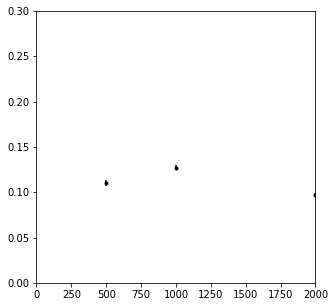

In [23]:
## Try plotting with std. error

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import colorConverter as cc
import numpy as np
 
def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    plt.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=.5)
    # plot the mean on top
    plt.plot(mean, color_mean)

mean0 = 1 - np.array(MnAccuracy.iloc[0])
ub0 = np.add(mean0, list(StdAccuracy.iloc[0]))
lb0 = np.subtract(mean0, list(StdAccuracy.iloc[0]))

print(mean0)
print(ub0)
print(lb0)

mean1 = 1 - np.array(MnAccuracy.iloc[1])
ub1 = np.add(mean1, list(StdAccuracy.iloc[1]))
lb1 = np.subtract(mean1, list(StdAccuracy.iloc[1]))

mean2 = 1 - np.array(MnAccuracy.iloc[2])
ub2 = np.add(mean2, list(StdAccuracy.iloc[2]))
lb2 = np.subtract(mean2, list(StdAccuracy.iloc[2]))

print(StdAccuracy)
fig = plt.figure(100, figsize=(5, 5))
plt.axis([0,2000, 0, 0.3])
#plot_mean_and_CI(mean0, ub0, lb0, color_mean='k', color_shading='k')
#plot_mean_and_CI(mean1, ub1, lb1, color_mean='b', color_shading='b')
#plot_mean_and_CI(mean2, ub2, lb2, color_mean='g--', color_shading='g')

localcomsize = np.array([500.0, 1000.0, 2000.0])

plt.plot(mean0, localcomsize)
print(mean0)
print(localcomsize)

plt.plot(localcomsize, mean0, "go")

x = localcomsize
dy = list(StdAccuracy.iloc[2])
y = mean0

plt.errorbar(x, y, yerr=dy, fmt='.k')